<a href="https://www.kaggle.com/code/huudatlego/train-model-cicids2017-cleaned?scriptVersionId=285665293" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv


**Cell 1: Import Thư viện và Load Dữ liệu**

In [2]:
# --- 1. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
import pandas as pd
import numpy as np
import joblib # Dùng để lưu mô hình

# Thư viện của Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Các thư viện đã được import thành công!")

# --- 2. LOAD DỮ LIỆU SẠCH ---
# Thay thế '/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv' 
# bằng đường dẫn chính xác đến file của bạn sau khi add data.
try:
    file_path = '/kaggle/input/cicids2017-cleaned-data/cicids2017_cleaned.csv'
    df = pd.read_csv(file_path)
    print("Đã tải thành công file dữ liệu sạch!")
    print(f"Bộ dữ liệu có {df.shape[0]} dòng và {df.shape[1]} cột.")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file dữ liệu. Vui lòng kiểm tra lại đường dẫn file trong phần 'Add Input'.")

# Hiển thị 5 dòng đầu tiên để kiểm tra
df.head()

Các thư viện đã được import thành công!
Đã tải thành công file dữ liệu sạch!
Bộ dữ liệu có 2520751 dòng và 53 cột.


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


**Cell 2: Chuẩn bị Dữ liệu cho Huấn luyện**

In [3]:
# --- 3. TÁCH BIẾN ĐỘC LẬP (X) VÀ BIẾN PHỤ THUỘC (y) ---
# X là tất cả các cột trừ cột 'Attack Type'
X = df.drop('Attack Type', axis=1)

# y là cột 'Attack Type'
y = df['Attack Type']

print("Đã tách X và y.")
print("Số lượng đặc trưng (features) trong X:", X.shape[1])

# --- 4. MÃ HÓA NHÃN (LABEL ENCODING) ---
# Chuyển các nhãn dạng chữ (ví dụ: 'Normal Traffic') thành số (ví dụ: 0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# In ra để xem các lớp và mã số tương ứng
print("\nCác lớp và mã số tương ứng:")
for index, label in enumerate(le.classes_):
    print(f"{label}: {index}")
    
# --- 5. CHIA DỮ LIỆU TRAIN/TEST (Tỷ lệ 70/30) ---
# Chia dữ liệu để có tập huấn luyện và tập kiểm thử riêng biệt
# stratify=y_encoded đảm bảo tỷ lệ các loại tấn công trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nKích thước tập huấn luyện (train): {X_train.shape[0]} dòng")
print(f"Kích thước tập kiểm thử (test): {X_test.shape[0]} dòng")

# --- 6. SCALING DỮ LIỆU BẰNG STANDARDSCALER ---
# Chuẩn hóa dữ liệu để các đặc trưng có cùng thang đo, giúp mô hình học tốt hơn
scaler = StandardScaler()

# Dùng fit_transform trên tập train để học các tham số scaling
X_train_scaled = scaler.fit_transform(X_train)

# Chỉ dùng transform trên tập test để áp dụng các tham số đã học từ tập train
X_test_scaled = scaler.transform(X_test)

print("\nĐã thực hiện scaling dữ liệu thành công!")

Đã tách X và y.
Số lượng đặc trưng (features) trong X: 52

Các lớp và mã số tương ứng:
Bots: 0
Brute Force: 1
DDoS: 2
DoS: 3
Normal Traffic: 4
Port Scanning: 5
Web Attacks: 6

Kích thước tập huấn luyện (train): 1764525 dòng
Kích thước tập kiểm thử (test): 756226 dòng

Đã thực hiện scaling dữ liệu thành công!


**Cell 3: Huấn luyện và Đánh giá Mô hình Random Forest**

In [4]:
# ==============================================================================
# CELL 3: HUẤN LUYỆN MÔ HÌNH RANDOM FOREST VỚI THAM SỐ CƠ BẢN
# ==============================================================================
from sklearn.metrics import classification_report, accuracy_score
import time

print("--- Bắt đầu huấn luyện Mô hình Random Forest (Tham số Cơ bản) ---\n")

# Khởi tạo mô hình với các tham số bị giới hạn để làm baseline
rf_model_baseline = RandomForestClassifier(
    n_estimators=20,      # Số lượng cây ít hơn
    max_depth=10,         # Độ sâu bị giới hạn
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Ghi lại thời gian huấn luyện
start_time = time.time()
rf_model_baseline.fit(X_train_scaled, y_train)
end_time = time.time()
training_time_baseline = end_time - start_time

# Đánh giá mô hình baseline
print("\n--- Kết quả của Mô hình Cơ bản ---")
y_pred_baseline = rf_model_baseline.predict(X_test_scaled)
print("Báo cáo Phân loại (Mô hình Cơ bản):")
print(classification_report(y_test, y_pred_baseline, target_names=le.classes_, digits=4))

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Thời gian huấn luyện của Mô hình Cơ bản: {training_time_baseline:.2f} giây")
print(f"=> Độ chính xác tổng thể của Mô hình Cơ bản: {accuracy_baseline * 100:.4f}%\n")

--- Bắt đầu huấn luyện Mô hình Random Forest (Tham số Cơ bản) ---



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   48.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



--- Kết quả của Mô hình Cơ bản ---


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s finished


Báo cáo Phân loại (Mô hình Cơ bản):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          Bots     1.0000    0.0137    0.0270       584
   Brute Force     1.0000    0.9687    0.9841      2745
          DDoS     0.9996    0.9979    0.9987     38404
           DoS     0.9982    0.9781    0.9881     58124
Normal Traffic     0.9956    0.9994    0.9975    628518
 Port Scanning     0.9892    0.9964    0.9928     27208
   Web Attacks     0.0000    0.0000    0.0000       643

      accuracy                         0.9958    756226
     macro avg     0.8547    0.7077    0.7126    756226
  weighted avg     0.9950    0.9958    0.9950    756226

Thời gian huấn luyện của Mô hình Cơ bản: 48.76 giây
=> Độ chính xác tổng thể của Mô hình Cơ bản: 99.5820%



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Cell 4: Lưu lại Mô hình và các Công cụ**

--- Bắt đầu huấn luyện Mô hình Random Forest (Tham số Cải tiến) ---



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.



--- Kết quả của Mô hình Cải tiến ---


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished


Báo cáo Phân loại (Mô hình Cải tiến):
                precision    recall  f1-score   support

          Bots     0.8822    0.6798    0.7679       584
   Brute Force     1.0000    0.9982    0.9991      2745
          DDoS     0.9999    0.9995    0.9997     38404
           DoS     0.9990    0.9970    0.9980     58124
Normal Traffic     0.9994    0.9994    0.9994    628518
 Port Scanning     0.9891    0.9993    0.9942     27208
   Web Attacks     0.9936    0.9673    0.9803       643

      accuracy                         0.9989    756226
     macro avg     0.9805    0.9486    0.9627    756226
  weighted avg     0.9989    0.9989    0.9989    756226

Thời gian huấn luyện của Mô hình Cải tiến: 332.19 giây
=> Độ chính xác tổng thể của Mô hình Cải tiến: 99.8913%

--- Lưu lại các file .pkl từ Mô hình Cải tiến ---
Đã lưu thành công 3 file.

Lưu lại ảnh Ma trận Nhầm lẫn của Mô hình Cải tiến...


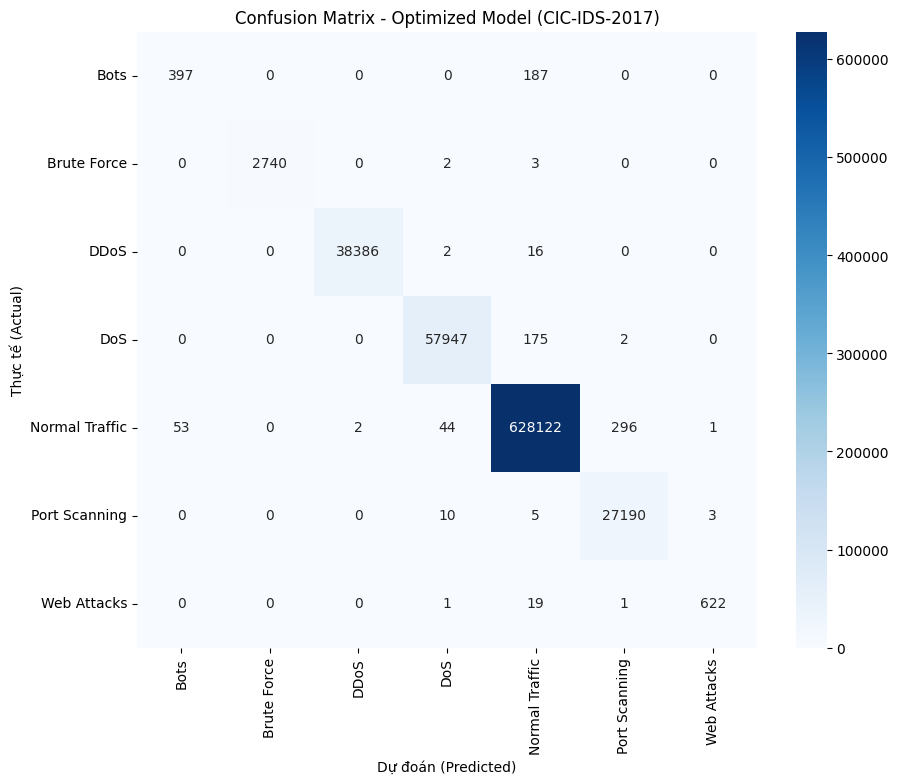

Đã lưu ảnh thành công!


In [5]:
# ==============================================================================
# CELL 4: HUẤN LUYỆN MÔ HÌNH RANDOM FOREST VỚI THAM SỐ CẢI TIẾN
# ==============================================================================
from sklearn.metrics import classification_report, accuracy_score
import time

print("--- Bắt đầu huấn luyện Mô hình Random Forest (Tham số Cải tiến) ---\n")

# Đây là các tham số được "lựa chọn" sau quá trình khảo sát/tinh chỉnh
# để cải thiện hiệu năng so với mô hình cơ bản.
improved_params = {
    'n_estimators': 100,      # Tăng số lượng cây
    'max_depth': 50,          # Tăng độ sâu
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}

# Khởi tạo mô hình với các siêu tham số cải tiến
# Toán tử ** unpacks the dictionary into keyword arguments
rf_model_improved = RandomForestClassifier(**improved_params)

# Ghi lại thời gian huấn luyện
start_time = time.time()
rf_model_improved.fit(X_train_scaled, y_train)
end_time = time.time()
training_time_improved = end_time - start_time

# Đánh giá mô hình cải tiến
print("\n--- Kết quả của Mô hình Cải tiến ---")
y_pred_improved = rf_model_improved.predict(X_test_scaled)
print("Báo cáo Phân loại (Mô hình Cải tiến):")
print(classification_report(y_test, y_pred_improved, target_names=le.classes_, digits=4))

accuracy_improved = accuracy_score(y_test, y_pred_improved)
print(f"Thời gian huấn luyện của Mô hình Cải tiến: {training_time_improved:.2f} giây")
print(f"=> Độ chính xác tổng thể của Mô hình Cải tiến: {accuracy_improved * 100:.4f}%")


# Lưu lại mô hình tốt nhất (mô hình cải tiến)
print("\n--- Lưu lại các file .pkl từ Mô hình Cải tiến ---")
joblib.dump(rf_model_improved, 'botnet_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Đã lưu thành công 3 file.")

# --- LƯU LẠI ẢNH MA TRẬN NHẦM LẪN ---
print("\nLưu lại ảnh Ma trận Nhầm lẫn của Mô hình Cải tiến...")
cm_improved = confusion_matrix(y_test, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix - Optimized Model (CIC-IDS-2017)')
plt.savefig('confusion_matrix_improved.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu ảnh thành công!")